# **Necessary Libraries**

In [1]:
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [2]:
!pip install -q tensorflow-docs
!pip install -q opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.4 MB/s eta 0:00:00


# **Loading and Preprocessing the Video Data**

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

DATASET_PATH = "/content/drive/MyDrive/Cellula Technology/Shop Classification/Shop DataSet"
classes = ["shop lifters", "non shop lifters"]

video_paths = []
labels = []

for i, class_name in enumerate(classes):
 class_path = os.path.join(DATASET_PATH, class_name)
 for filename in os.listdir(class_path):
  video_paths.append(os.path.join(class_path, filename))
  labels.append(i)

# Splitting the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)

In [ ]:
print("Number of training videos:", len(train_paths))
print("Number of validation videos:", len(val_paths))
print("Number of testing videos:", len(test_paths))

Number of training videos: 547
Number of validation videos: 137
Number of testing videos: 171


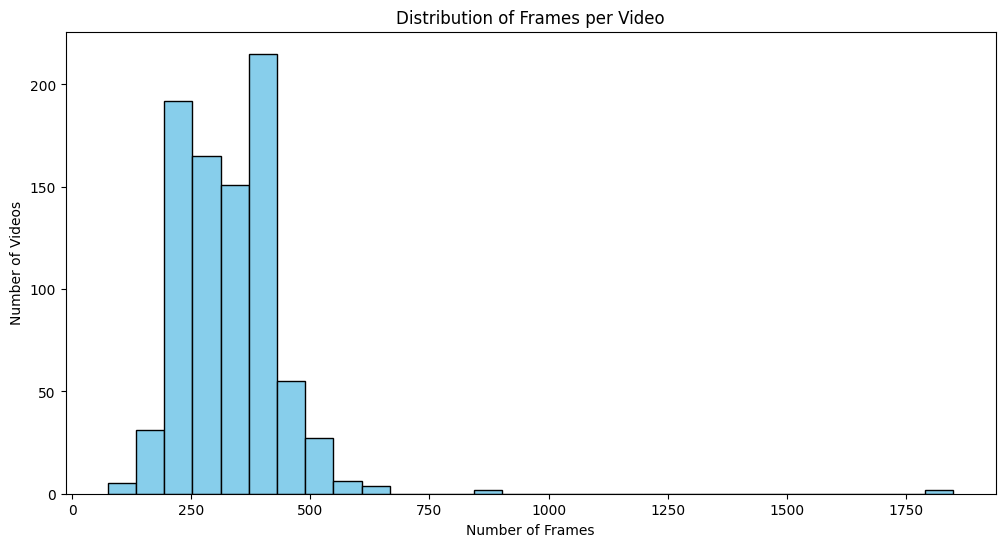

In [4]:
def extract_frames(video_path, max_frames=20, resize=(128, 128)):
 frames = []
 cap = cv2.VideoCapture(video_path)
 frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

 for i in range(max_frames):
  ret, frame = cap.read()
  if not ret:
   break
  frame = cv2.resize(frame, resize)
  frames.append(frame)

 cap.release()
 return np.array(frames), frame_count

# Visualize frame counts
frame_counts = [extract_frames(p)[1] for p in video_paths]

plt.figure(figsize=(12, 6))
plt.hist(frame_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Frames per Video")
plt.xlabel("Number of Frames")
plt.ylabel("Number of Videos")
plt.show()

In [5]:
def prepare_data(video_paths, labels, max_frames=20, resize=(128, 128)):
    X, y = [], []
    for path, label in zip(video_paths, labels):
        frames, _ = extract_frames(path, max_frames, resize)
        if frames.shape[0] == max_frames:
            X.append(frames)
            y.append(label)
    return np.array(X) / 255.0, np.array(y)

X_train, y_train = prepare_data(train_paths, train_labels)
X_val, y_val = prepare_data(val_paths, val_labels)
X_test, y_test = prepare_data(test_paths, test_labels)

# **Building the CNN-RNN Model**

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def create_cnn_rnn_model(input_shape, num_classes):
 # CNN base for feature extraction
 base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape[1:])
 base_model.trainable = False

 # Model architecture
 frame_input = Input(shape=input_shape)
 cnn_features = TimeDistributed(base_model)(frame_input)

 # RNN for sequence modeling
 rnn_output = GRU(64, return_sequences=False)(cnn_features)
 rnn_output = Dropout(0.5)(rnn_output)

 # Classification head
 output = Dense(num_classes, activation='softmax')(rnn_output)

 model = Model(inputs=frame_input, outputs=output)
 return model

model = create_cnn_rnn_model(X_train.shape[1:], len(classes))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       258,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,516,546 (9.60 MB)

 Trainable params: 258,562 (1010.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path to save the best model
best_model_path = "best_video_classifier_model.h5"

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath=best_model_path,
                                    monitor='val_loss',
                                    save_best_only=True,
                                    verbose=1)

In [8]:
# Create the model (using the function defined in the previous answer)
model = create_cnn_rnn_model(X_train.shape[1:], len(classes))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6416 - loss: 0.7036
Epoch 1: val_loss improved from inf to 0.70895, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 304s 7s/step - accuracy: 0.6435 - loss: 0.7007 - val_accuracy: 0.6204 - val_loss: 0.7090
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7273 - loss: 0.5859
Epoch 2: val_loss improved from 0.70895 to 0.28118, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 212s 6s/step - accuracy: 0.7288 - loss: 0.5832 - val_accuracy: 0.8759 - val_loss: 0.2812
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8041 - loss: 0.4437
Epoch 3: val_loss improved from 0.28118 to 0.26419, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.8041 - loss: 0.4433 - val_accuracy: 0.8978 - val_loss: 0.2642
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8517 - loss: 0.3847
Epoch 4: val_loss improved from 0.26419 to 0.19407, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.8525 - loss: 0.3827 - val_accuracy: 0.9124 - val_loss: 0.1941
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9088 - loss: 0.2065
Epoch 5: val_loss improved from 0.19407 to 0.10343, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.9090 - loss: 0.2065 - val_accuracy: 0.9635 - val_loss: 0.1034
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9594 - loss: 0.1131
Epoch 6: val_loss improved from 0.10343 to 0.07742, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.9598 - loss: 0.1123 - val_accuracy: 0.9708 - val_loss: 0.0774
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9771 - loss: 0.0813
Epoch 7: val_loss improved from 0.07742 to 0.07620, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.9766 - loss: 0.0823 - val_accuracy: 0.9854 - val_loss: 0.0762
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9671 - loss: 0.1004
Epoch 8: val_loss did not improve from 0.07620
35/35 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.9673 - loss: 0.0997 - val_accuracy: 0.9270 - val_loss: 0.1322
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9798 - loss: 0.0643
Epoch 9: val_loss did not improve from 0.07620
35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.9799 - loss: 0.0642 - val_accuracy: 0.8613 - val_loss: 0.4343
Epoch 10/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9290 - loss: 0.2086
Epoch 10: val_loss did not improve from 0.07620
35/35 ━━━━━━━━━━━━━━━━━━━━ 216s 6s/step - accuracy: 0.9298 - loss: 0.2062 - val_accuracy: 0.9562 - val_loss: 0.0809
Epoch 11/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9887 - loss: 0.0594
Epoch 11: val_loss improved from 0.07620 to 0.01855, saving 

35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.9886 - loss: 0.0592 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 12/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9377 - loss: 0.1578
Epoch 12: val_loss did not improve from 0.01855
35/35 ━━━━━━━━━━━━━━━━━━━━ 212s 6s/step - accuracy: 0.9376 - loss: 0.1579 - val_accuracy: 0.9781 - val_loss: 0.0728
Epoch 13/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9847 - loss: 0.0653
Epoch 13: val_loss did not improve from 0.01855
35/35 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - accuracy: 0.9848 - loss: 0.0650 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 14/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9814 - loss: 0.0452
Epoch 14: val_loss improved from 0.01855 to 0.00620, saving model to best_video_classifier_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - accuracy: 0.9814 - loss: 0.0452 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 15/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9766 - loss: 0.0841
Epoch 15: val_loss did not improve from 0.00620
35/35 ━━━━━━━━━━━━━━━━━━━━ 212s 6s/step - accuracy: 0.9752 - loss: 0.0877 - val_accuracy: 0.8905 - val_loss: 0.2563
Restoring model weights from the end of the best epoch: 14.


6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.9974 - loss: 0.0224
Test Accuracy: 0.9942
Test Loss: 0.0375


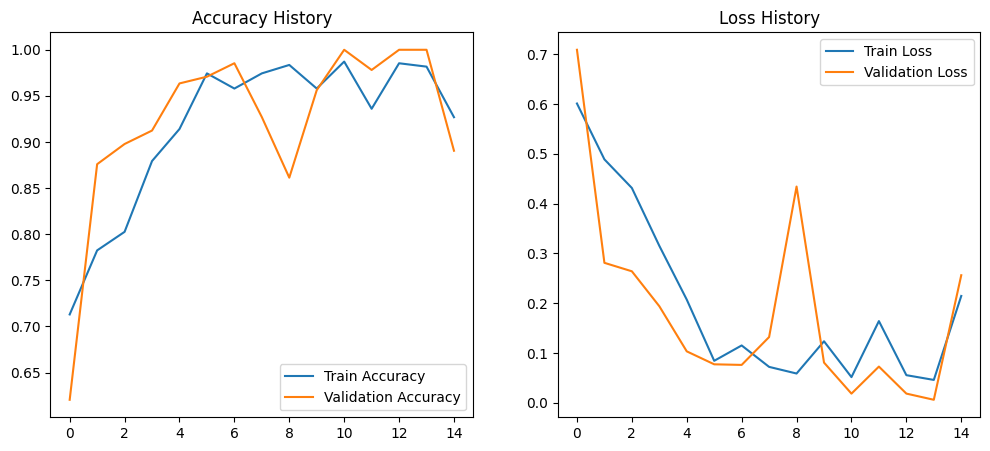

In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
# This visualization helps you see when EarlyStopping might have kicked in
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss History')

plt.show()

In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate and print the classification report
report = classification_report(y_test, y_pred, target_names=classes)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 91s 12s/step
                  precision    recall  f1-score   support

    shop lifters       1.00      0.99      0.99        67
non shop lifters       0.99      1.00      1.00       104

        accuracy                           0.99       171
       macro avg       1.00      0.99      0.99       171
    weighted avg       0.99      0.99      0.99       171



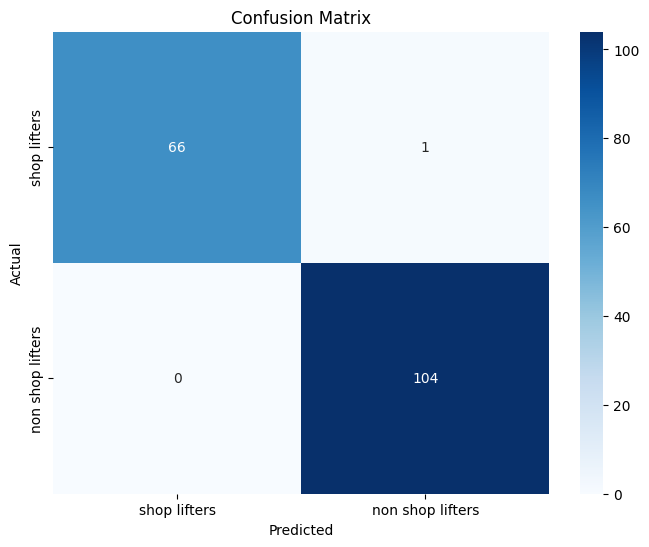

In [11]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()